In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ast, os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_yaml
tf.__version__

'2.2.0'

In [65]:
df = pd.read_csv('../../Data/Flujo2.csv', sep=";")
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)

In [66]:
def enumerate_dimensions(dimension, list_dimensions): 
    return list_dimensions.index(dimension)
def wordsToNumbers(tokens, vocabulary):
    number_array = []
    for i in tokens:
        number_array.append(vocabulary.index(i)+1)
    return np.asarray(number_array)

In [67]:
# Se Construye Dataframe solo de medio ambiente
df = df[df.Area == 'Gobierno Corporativo']
# Lista de dimensiones se pasa a numeros
list_dimensions = df.Dimension.unique().tolist()
num_classes = len(list_dimensions)
df['_dimension'] = df['Dimension'].apply(enumerate_dimensions, list_dimensions = list_dimensions)

#Generamos un vocabulario de palabras
vocabulary = []
df['Respuesta'].apply(vocabulary.append)
vocabulary = [item for sublist in vocabulary for item in sublist]
vocabulary.append('')
vocabulary = list(sorted(set(vocabulary)))
vocab_len= len(vocabulary)+1

df['NumRespuesta'] = df.Respuesta.apply (wordsToNumbers, vocabulary = vocabulary)

# Rellenamos las matrices con 0 para que todas tengan el mismo tamaño
X_completo = pad_sequences(df.NumRespuesta, maxlen=10, dtype='object', padding='post', value = 0)
y_completo = np.array(df['_dimension'])
df.groupby('_dimension').count()

,Area,Dimension,Respuesta,NumRespuesta
_dimension,,,,
0,7004,7004,7004,7004
1,7186,7186,7186,7186


# Busqueda de Hyperparametros

In [55]:
def gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y, paramsEmbedding, paramsLSTM, num_clases, optimizer, batch_size, epoch):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = paramsEmbedding['input_dim'],  output_dim = paramsEmbedding['output_dim'], input_shape=(tensor_X.shape[1],)))
    model.add(tf.keras.layers.LSTM(units = paramsLSTM['units'],
                                   activation = paramsLSTM['activation'],
                                   dropout = paramsLSTM['dropout'],
                                   recurrent_dropout = paramsLSTM['recurrent_dropout']))
    
    model.add(tf.keras.layers.Dense(units = num_clases ,activation='softmax'))
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose = 0
                       )
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions )
    print(medidas[0])
    return [test_acurracy, test_loss, medidas, paramsEmbedding, paramsLSTM, optimizer, batch_size, epoch]


def grid_lstm(data_x, data_y, input_dim, output_dim_embe, units_lstm, activ_lstm, drop_lstm, rec_drop_lstm, num_clases, optimizers, batch_size_, epochs):
    X, test_x, y, test_y = train_test_split(data_x, data_y, test_size = 0.1, random_state = 0)
    tensor_X      = tf.convert_to_tensor(list(X))
    tensor_test_x = tf.convert_to_tensor(list(test_x))
    tensor_y      = tf.convert_to_tensor(list(y))
    tensor_test_y = tf.convert_to_tensor(list(test_y))
    resultados = []
    for output_dim in output_dim_embe:
        for units in units_lstm:
            for activ in activ_lstm:
                for drop in drop_lstm:
                    for rec_drop in rec_drop_lstm:
                        for optimizer in optimizers:
                            for batch_size in batch_size_:
                                for epoch in epochs:
                                    resultados.append( gen_train_model(tensor_X, tensor_y, tensor_test_x, tensor_test_y,  
                                                                       {'output_dim':output_dim}, 
                                                                       {'units':units,'activation':activ,'dropout':drop, 'recurrent_dropout':rec_drop},
                                                                       {'optimizador': optimizer, 'batch_size': batch_size, 'epoch': epoch}
                                                                      )
                                                     )
    return resultados

output = grid_lstm(data_x = X_completo,
          data_y = y_completo,
          input_dim = len(vocabulary)+1,
          num_clases = len(list_dimensions),
          output_dim_embe = [60],
          units_lstm = [90, 130],
          activ_lstm = ['tanh', 'sigmoid', 'relu','softmax'],
          drop_lstm = [0.3,0.5,0.7],
          rec_drop_lstm = [0.3,0.5,0.7],
          optimizers = ['rmsprop','adam'],
          batch_size_ = [20, 40],
          epochs = [6,8]
         )

TypeError: gen_train_model() missing 3 required positional arguments: 'optimizer', 'batch_size', and 'epoch'

In [61]:
#Mejor resultado segun media de la precisión
medias_pres_ = [out[2][0].mean() for out in output]
print(medias_pres_.index(max(medias_pres_)))
output[medias_pres_.index(max(medias_pres_))]

202


[0.7984496355056763,
 0.4675550162792206,
 (array([0.7654321 , 0.83333333]),
  array([0.82912333, 0.77077748]),
  array([0.79600571, 0.80083565]),
  array([673, 746], dtype=int64)),
 {'input_dim': 8088, 'output_dim': 60},
 {'units': 90, 'activation': 'relu', 'dropout': 0.7, 'recurrent_dropout': 0.5},
 'rmsprop',
 40,
 6]

# K-means con parametros encontrados

In [68]:
epoch = 6
batch_size = 40
optimizer = 'rmsprop'
recurrent_dropout = 0.5
dropout = 0.7
activation_lstm = 'relu'
lstm_units = 90
ouput_dim_embedding = 60

kf = KFold(n_splits = 10, shuffle = True, random_state = 2)
resultados = []
contador = 1
for valores_entrenamiento, valores_testeo in kf.split(X_completo):
    tensor_X      = tf.convert_to_tensor(list(X_completo[valores_entrenamiento]))
    tensor_test_x = tf.convert_to_tensor(list(X_completo[valores_testeo]))
    tensor_y      = tf.convert_to_tensor(list(y_completo[valores_entrenamiento]))
    tensor_test_y = tf.convert_to_tensor(list(y_completo[valores_testeo]))
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim = vocab_len, 
                                        output_dim = ouput_dim_embedding,
                                        input_shape=(X_completo.shape[1],)))
    model.add(tf.keras.layers.LSTM(units=lstm_units,
                                   activation=activation_lstm,
                                   dropout = dropout,
                                   recurrent_dropout = recurrent_dropout))
    model.add(tf.keras.layers.Dense(units=num_classes,
                                    activation='sigmoid'))
    model.compile(optimizer = optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    history = model.fit(tensor_X,
                        tensor_y,
                        epochs = epoch,
                        batch_size = batch_size,
                        verbose=0)
    test_loss, test_acurracy = model.evaluate(tensor_test_x,
                                              tensor_test_y,
                                              verbose=0
                                             )
    predictions = model.predict_classes(tensor_test_x)
    medidas = precision_recall_fscore_support(tensor_test_y, predictions)
    resultados.append([test_loss, test_acurracy, medidas])
    
model.save('../Modelos/Flujo2/model_gob.h5')

In [69]:
print("loss mean",np.array([res[0] for res in resultados]).mean())
print("acurracy mean",np.array([res[1] for res in resultados]).mean())
print("media precision clase 0",np.array([res[2][0][0] for res in resultados]).mean())
print("media precision clase 1",np.array([res[2][0][1] for res in resultados]).mean())

print("media recall clase 0",np.array([res[2][1][0] for res in resultados]).mean())
print("media recall clase 1",np.array([res[2][1][1] for res in resultados]).mean())

print("media fscore clase 0",np.array([res[2][2][0] for res in resultados]).mean())
print("media fscore clase 1",np.array([res[2][2][1] for res in resultados]).mean())

loss mean 0.45870194733142855
acurracy mean 0.7868217051029205
media precision clase 0 0.787578757444547
media precision clase 1 0.7885341612835834
media recall clase 0 0.7802156226077356
media recall clase 1 0.7935511475325725
media fscore clase 0 0.7828531302775806
media fscore clase 1 0.7900453314161847


In [61]:
#model.save('../Modelos/Flujo2/model_gob.h5')
#model_ = tf.keras.models.load_model('complete_model_gob.h5')

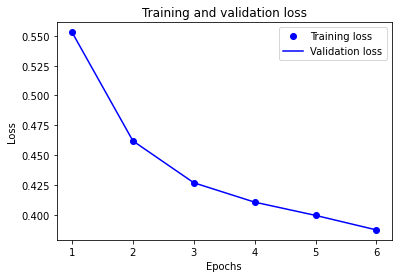

In [70]:
import matplotlib.pyplot as plt
history_dict = history.history
acc = history_dict['sparse_categorical_accuracy']
loss = history_dict['loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("../Imagenes/RNN/GOB/T&V_loss_GOB_2.png")

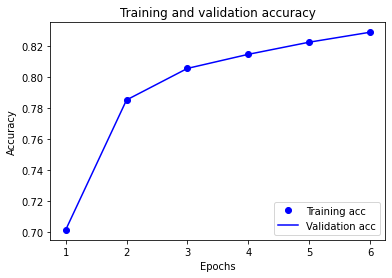

In [71]:
plt.clf()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig("../Imagenes/RNN/GOB/T&V_acc_GOB_2.png")

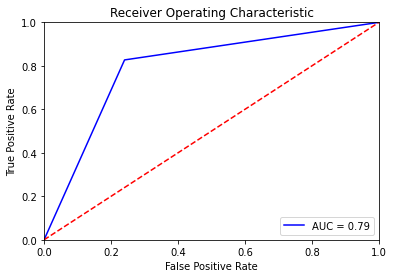

In [72]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_completo[valores_testeo], predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("../Imagenes/RNN/GOB/ROC_GOB_2.png")